In [943]:
%matplotlib inline
import os
import re
import io
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [944]:
DIR_FORTRAN_CLIRAD = os.path.join('/chia_cluster/home/jackyu',
                                  'radiation',
                                  'clirad-lw/LW/examples/lblnew/now')

PATH_FLUX_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                'output_flux.dat')
PATH_COOLR_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                 'output_coolr.dat')
PATH_FLUXG_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                 'output_fluxg.dat')
PATH_COOLRG_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                  'output_coolrg.dat')

In [945]:
# option_wgt_flux = 2
DIR_FORTRAN_LBLNEW = os.path.join('/chia_cluster/home/jackyu',
                                  'radiation/crd/LW/examples',
                                  'separate_g_groups',
                                  'study__lblnew_g1_threshold',
                                  'h2o/band01_wn_20_340/nv_200',
                                  'dv_0.005/ng_10',
                                  'g_ascending_k_descending',
                                  'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                                  'ng_refs_3__2__5',
                                  'getabsth_auto__auto__auto',
                                  'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                                  'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                                  'wgt_flux_2/wgt_k_1/klin_none',
                                  'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                                  'crd_9d81085',
                                  'atmpro_mls')
# CRD
PATH_FLUXG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW, 
                                 'output_fluxg.dat')
PATH_COOLRG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW, 
                                  'output_coolrg.dat')

# k-dist, diffusivity, table look-up
PATH_WWFLUXG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW,
                                   'output_wwfluxg.dat')
PATH_WWCOOLRG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW,
                                    'output_wwcoolrg.dat')

In [946]:
# option_wgt_flux = 1
DIR_FORTRAN_LBLNEW1 = os.path.join('/chia_cluster/home/jackyu',
                                  'radiation/crd/LW/examples',
                                  'separate_g_groups',
                                  'study__lblnew_g1_threshold',
                                  'h2o/band01_wn_20_340/nv_200',
                                  'dv_0.005/ng_10',
                                  'g_ascending_k_descending',
                                  'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                                  'ng_refs_3__2__5',
                                  'getabsth_auto__auto__auto',
                                  'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                                  'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                                  'wgt_flux_1/wgt_k_1/klin_none',
                                  'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                                  'crd_08fbde8',
                                  'atmpro_mls')

# CRD
PATH_FLUXG_LBLNEW1 = os.path.join(DIR_FORTRAN_LBLNEW1, 
                                 'output_fluxg.dat')
PATH_COOLRG_LBLNEW1 = os.path.join(DIR_FORTRAN_LBLNEW1, 
                                  'output_coolrg.dat')

# k-dist, diffusivity, table look-up
PATH_WWFLUXG_LBLNEW1 = os.path.join(DIR_FORTRAN_LBLNEW1,
                                   'output_wwfluxg.dat')
PATH_WWCOOLRG_LBLNEW1 = os.path.join(DIR_FORTRAN_LBLNEW1,
                                    'output_wwcoolrg.dat')

In [947]:
# option_wgt_flux = 2, bu = bd = blayer
DIR_FORTRAN_LBLNEW2 = os.path.join('/chia_cluster/home/jackyu',
                                  'radiation/crd/LW/examples',
                                  'separate_g_groups',
                                  'study__lblnew_g1_threshold',
                                  'h2o/band01_wn_20_340/nv_200',
                                  'dv_0.005/ng_10',
                                  'g_ascending_k_descending',
                                  'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                                  'ng_refs_3__2__5',
                                  'getabsth_auto__auto__auto',
                                  'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                                  'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                                  'wgt_flux_2/wgt_k_1/klin_none',
                                  'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                                  'crd_ea0cb67',
                                  'atmpro_mls')

# CRD
PATH_FLUXG_LBLNEW2 = os.path.join(DIR_FORTRAN_LBLNEW1, 
                                 'output_fluxg.dat')
PATH_COOLRG_LBLNEW2 = os.path.join(DIR_FORTRAN_LBLNEW1, 
                                  'output_coolrg.dat')

# k-dist, diffusivity, table look-up
PATH_WWFLUXG_LBLNEW2 = os.path.join(DIR_FORTRAN_LBLNEW1,
                                   'output_wwfluxg.dat')
PATH_WWCOOLRG_LBLNEW2 = os.path.join(DIR_FORTRAN_LBLNEW1,
                                    'output_wwcoolrg.dat')

In [948]:
def load_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['band', 'pressure', 'igg', 'g']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    df = df.rename(columns={'sfu': 'flug',
                           'sfd': 'fldg',
                           'fnet': 'fnetg',
                           'coolr': 'coolrg'})
    ds = xr.Dataset.from_dataframe(df)
    return ds

In [949]:
DS_FLUX_CLIRAD = load_output_file(PATH_FLUX_CLIRAD)
DS_COOLR_CLIRAD = load_output_file(PATH_COOLR_CLIRAD)
DS_FLUXG_CLIRAD = load_output_file(PATH_FLUXG_CLIRAD)
DS_COOLRG_CLIRAD = load_output_file(PATH_COOLRG_CLIRAD)

In [950]:
DS_FLUXG_LBLNEW = load_output_file(PATH_FLUXG_LBLNEW)
DS_COOLRG_LBLNEW = load_output_file(PATH_COOLRG_LBLNEW)
DS_WWFLUXG_LBLNEW = load_output_file(PATH_WWFLUXG_LBLNEW)
DS_WWCOOLRG_LBLNEW = load_output_file(PATH_WWCOOLRG_LBLNEW)

In [951]:
DS_FLUXG_LBLNEW1 = load_output_file(PATH_FLUXG_LBLNEW1)
DS_COOLRG_LBLNEW1 = load_output_file(PATH_COOLRG_LBLNEW1)
DS_WWFLUXG_LBLNEW1 = load_output_file(PATH_WWFLUXG_LBLNEW1)
DS_WWCOOLRG_LBLNEW1 = load_output_file(PATH_WWCOOLRG_LBLNEW1)

In [952]:
DS_FLUXG_LBLNEW2 = load_output_file(PATH_FLUXG_LBLNEW2)
DS_COOLRG_LBLNEW2 = load_output_file(PATH_COOLRG_LBLNEW2)
DS_WWFLUXG_LBLNEW2 = load_output_file(PATH_WWFLUXG_LBLNEW2)
DS_WWCOOLRG_LBLNEW2 = load_output_file(PATH_WWCOOLRG_LBLNEW2)

In [953]:
def pltdata_cooling_1(ds_coolrg_clirad=None,
                      ds_coolr_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wwcoolrg_lblnew=None,
                      ds_wwcoolrg_lblnew1=None,
                      ds_wwcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CLIRAD `coolr_bands`',
             'linestyle': '--', 'color': '#e74c3c', 'marker': None,
             'srs': ds_coolr_clirad['coolrg'].sel(band=1)},
            {'label': 'CLIRAD `coolrk`',
             'linestyle': ':', 'color': 'cyan', 'marker': 'd',
             'srs': ds_coolrg_clirad['coolrg'].sel(band=1).sum('g')},
            {'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')}]
    return data


def pltdata_cooling_2(ds_coolrg_clirad=None,
                      ds_coolr_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wwcoolrg_lblnew=None,
                      ds_wwcoolrg_lblnew1=None,
                      ds_wwcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')},
            {'label': 'WWGT igg=10 wgt_flux=2',
             'linestyle': '-', 'color': 'orange', 'marker': '.',
             'srs': ds_wwcoolrg_lblnew['coolrg'].sel(igg=10).sum('g')},
            {'label': 'WWGT igg=10 wgt_flux=1',
             'linestyle': '--', 'color': 'black', 'marker': 'x',
             'srs': ds_wwcoolrg_lblnew1['coolrg'].sel(igg=10).sum('g')}]
    return data


def pltdata_cooling_3(ds_coolrg_clirad=None,
                      ds_coolr_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wwcoolrg_lblnew=None,
                      ds_wwcoolrg_lblnew1=None,
                      ds_wwcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CLIRAD `coolrk`',
             'linestyle': ':', 'color': 'cyan', 'marker': 'd',
             'srs': ds_coolrg_clirad['coolrg'].sel(band=1).sum('g')},
            {'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')},
            {'label': 'WWGT igg=10 wgt_flux=2',
             'linestyle': '-', 'color': 'orange', 'marker': '.',
             'srs': ds_wwcoolrg_lblnew['coolrg'].sel(igg=10).sum('g')}]
    return data


def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 3,
                 'grid': True,
                 'alpha': .5}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():

    matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'grey',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 
    for f in [pltdata_cooling_1, pltdata_cooling_2, pltdata_cooling_3]:
        pltdata = f(ds_coolr_clirad=DS_COOLR_CLIRAD,
                    ds_coolrg_clirad=DS_COOLRG_CLIRAD,
                    ds_coolrg_lblnew=DS_COOLRG_LBLNEW,
                    ds_coolrg_lblnew1=DS_COOLRG_LBLNEW1,
                    ds_coolrg_lblnew2=DS_COOLRG_LBLNEW2,
                    ds_wwcoolrg_lblnew=DS_WWCOOLRG_LBLNEW,
                    ds_wwcoolrg_lblnew1=DS_WWCOOLRG_LBLNEW1,
                    ds_wwcoolrg_lblnew2=DS_WWCOOLRG_LBLNEW2)

        fig, axs = plt_cooling(pltdata=pltdata)
    
        display.display(fig)
        print('Figure: Cooling rate profile comparison.')
    
        plt.close(fig)
    
    

In [954]:

def tbdata_flux(ds_fluxg_clirad=None,
                ds_flux_clirad=None,
                ds_fluxg_lblnew=None,
                ds_fluxg_lblnew1=None,
                ds_wwfluxg_lblnew=None,
                ds_wwfluxg_lblnew1=None,
                ds_wwfluxg_lblnew2=None):
    ilevels = [0, -1]
    
    def fmt(ds):
        return ds.isel(pressure=ilevels)\
                 .to_dataframe()\
                 .set_index('level', append=True)
            
    benchmark = {'label': 'WWGT igg=10 wgt_flux=2',
                 'df': fmt(ds_wwfluxg_lblnew.sel(igg=10))}
    
    tbs = [{'label': 'WWGT igg=10 wgt_flux=1',
            'df': fmt(ds_wwfluxg_lblnew1.sel(igg=10))},
           {'label': 'WWGT igg=10 wgt_flux=2 bu=bd',
            'df': fmt(ds_wwfluxg_lblnew2.sel(igg=10))}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data


def tb_flux(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table:', 'TOA and SFC flux.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        df = d['df']
        df.index = d0['df'].index
        display.display(df - d0['df'])
        print('Table:', 'TOA and SFC flux.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)
        
        
def script_tb_fluxg():
    data = tbdata_flux(ds_fluxg_clirad=DS_FLUXG_CLIRAD,
                       ds_flux_clirad=DS_FLUX_CLIRAD,
                       ds_fluxg_lblnew=DS_FLUXG_LBLNEW,
                       ds_fluxg_lblnew1=DS_FLUXG_LBLNEW1,
                       ds_wwfluxg_lblnew=DS_WWFLUXG_LBLNEW,
                       ds_wwfluxg_lblnew1=DS_WWFLUXG_LBLNEW1,
                       ds_wwfluxg_lblnew2=DS_WWFLUXG_LBLNEW2)
    tb_flux(tbdata=data)
    



In [955]:
def load_debug_bd():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_bd.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_xx():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_xx.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_h2oexps():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'h2oexp.csv')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['layer', 'g'])
    return df


def script_debug():
    display.display(display.Markdown('# Debug Info'))
    pd.set_option('display.max_rows', None)
    display.display(load_debug_bd())
    display.display(load_debug_xx())
    display.display(load_debug_h2oexps())
    pd.reset_option('display.max_rows')


In [956]:
# Check interpolation function's results

def load_ktest():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_ktest.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df


def load_ktable():
    s = os.path.join('/chia_cluster/home/jackyu/radiation',
                     'crd/LW/examples/separate_g_groups',
                     'study__lblnew_g1_threshold',
                     'h2o/band01_wn_20_340/nv_200',
                     'dv_0.005/ng_10',
                     'g_ascending_k_descending',
                     'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                     'ng_refs_3__2__5',
                     'getabsth_auto__auto__auto',
                     'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                     'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                     'wgt_flux_2/wgt_k_1/klin_none',
                     'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                     'crd_9d81085',
                     'atmpro_mls',
                     'ktable.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df



def plt_fractional_error():
    clirad = load_ktest()
    crd = load_ktable()
    
    #print(clirad[clirad['k'] < 0])
    #print(crd[crd['k'] < 0])
    
    clirad.index = crd.index
    diff = (clirad - crd) / crd
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 5))
    diff.hist(ax=ax, bins=20, color='grey', alpha=.6)
    ax.set_xlabel('fractional deviation')
    ax.set_ylabel('number of (P,T) pairs')
    
    return fig


def script_bilinear_interp():
    
    display.display(display.Markdown('# Bilinear interpolation'))
    
    fig = plt_fractional_error()
    display.display(fig)
    print('Figure. Fractional deviation of'
          ' interpolated absorption coefficient from CRD'
         ' at ktable (pressure, temperature) pairs')
    plt.close(fig)



In [957]:
#script_bilinear_interp()

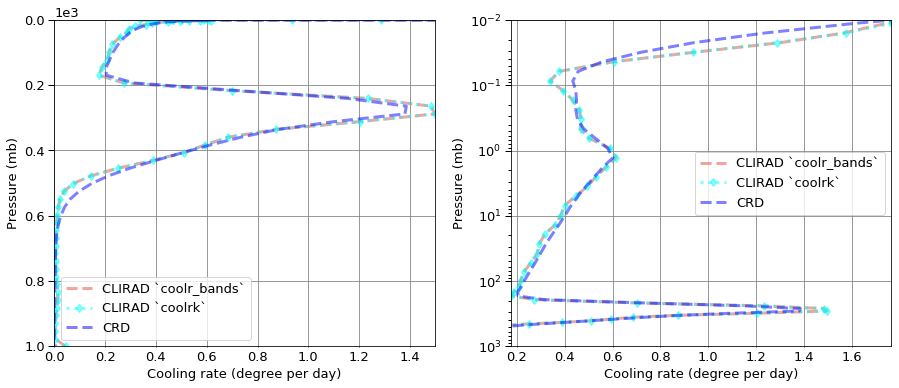

Figure: Cooling rate profile comparison.


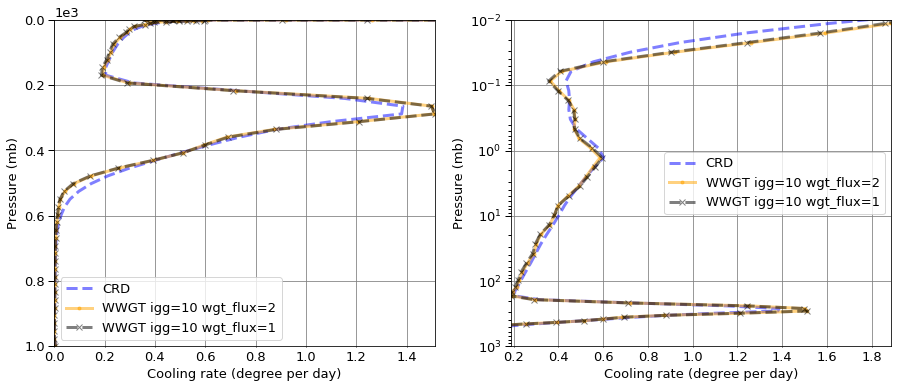

Figure: Cooling rate profile comparison.


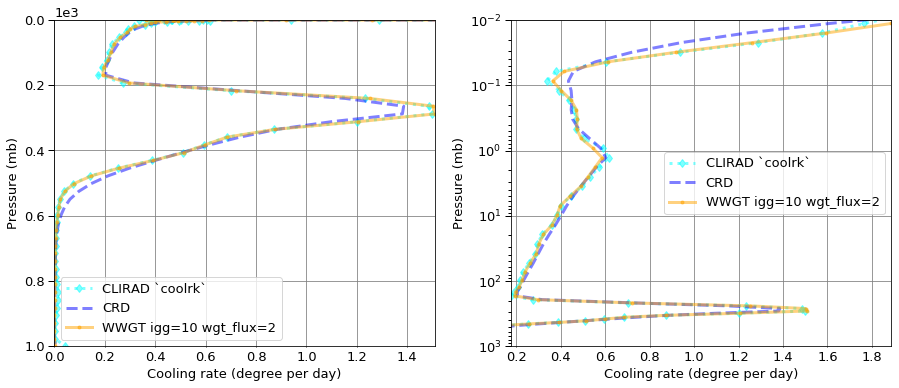

Figure: Cooling rate profile comparison.


In [958]:
script_plt_cooling()

In [959]:
script_tb_fluxg()

igg       flug       fldg      fnetg
g  pressure level                                      
1  0.0      1       10  -0.007170   0.000000  -0.007170
   1013.0   76      10  -0.012460   0.012457  -0.000003
2  0.0      1       10  -0.017788   0.000000  -0.017788
   1013.0   76      10  -0.025527   0.025521  -0.000007
3  0.0      1       10  -0.051052   0.000000  -0.051052
   1013.0   76      10  -0.060809   0.060794  -0.000015
4  0.0      1       10  -0.115529   0.000000  -0.115529
   1013.0   76      10  -0.142595   0.142560  -0.000035
5  0.0      1       10  -0.342374   0.000000  -0.342374
   1013.0   76      10  -0.477034   0.476917  -0.000117
6  0.0      1       10  -0.719158   0.000000  -0.719158
   1013.0   76      10  -1.119475   1.119201  -0.000274
7  0.0      1       10  -2.348260   0.000000  -2.348260
   1013.0   76      10  -3.892565   3.891610  -0.000954
8  0.0      1       10  -7.037135   0.000000  -7.037135
   1013.0   76      10 -11.170086  11.167328  -0.002758
9  0.0      1       10 -12.294151   0.000000 -12.294151
   1013.0   76      10 -18.390455  18.385790  -0.004664
10 0.0      1       10 -11.096962   0.000000 -11.096962
   1013.0   76      10 -15.782424  15.777921  -0.004503

Table: TOA and SFC flux. WWGT igg=10 wgt_flux=2


igg       flug       fldg      fnetg
g  pressure level                                      
1  0.0      1       10  -0.007073   0.000000  -0.007073
   1013.0   76      10  -0.012617   0.012614  -0.000003
2  0.0      1       10  -0.017761   0.000000  -0.017761
   1013.0   76      10  -0.025639   0.025632  -0.000007
3  0.0      1       10  -0.051327   0.000000  -0.051327
   1013.0   76      10  -0.061681   0.061665  -0.000016
4  0.0      1       10  -0.116010   0.000000  -0.116010
   1013.0   76      10  -0.145232   0.145195  -0.000038
5  0.0      1       10  -0.340839   0.000000  -0.340839
   1013.0   76      10  -0.486130   0.486003  -0.000127
6  0.0      1       10  -0.709382   0.000000  -0.709382
   1013.0   76      10  -1.141387   1.141089  -0.000298
7  0.0      1       10  -2.306029   0.000000  -2.306029
   1013.0   76      10  -3.966411   3.965376  -0.001035
8  0.0      1       10  -6.947725   0.000000  -6.947725
   1013.0   76      10 -11.356659  11.353695  -0.002964
9  0.0      1       10 -12.243630   0.000000 -12.243630
   1013.0   76      10 -18.550441  18.545599  -0.004842
10 0.0      1       10 -11.133825   0.000000 -11.133825
   1013.0   76      10 -15.327232  15.323231  -0.004001

Table: TOA and SFC flux. WWGT igg=10 wgt_flux=1


igg       flug       fldg      fnetg
g  pressure level                                      
1  0.0      1       10  -0.007073   0.000000  -0.007073
   1013.0   76      10  -0.012617   0.012614  -0.000003
2  0.0      1       10  -0.017761   0.000000  -0.017761
   1013.0   76      10  -0.025639   0.025632  -0.000007
3  0.0      1       10  -0.051327   0.000000  -0.051327
   1013.0   76      10  -0.061681   0.061665  -0.000016
4  0.0      1       10  -0.116010   0.000000  -0.116010
   1013.0   76      10  -0.145232   0.145195  -0.000038
5  0.0      1       10  -0.340839   0.000000  -0.340839
   1013.0   76      10  -0.486130   0.486003  -0.000127
6  0.0      1       10  -0.709382   0.000000  -0.709382
   1013.0   76      10  -1.141387   1.141089  -0.000298
7  0.0      1       10  -2.306029   0.000000  -2.306029
   1013.0   76      10  -3.966411   3.965376  -0.001035
8  0.0      1       10  -6.947725   0.000000  -6.947725
   1013.0   76      10 -11.356659  11.353695  -0.002964
9  0.0      1       10 -12.243630   0.000000 -12.243630
   1013.0   76      10 -18.550441  18.545599  -0.004842
10 0.0      1       10 -11.133825   0.000000 -11.133825
   1013.0   76      10 -15.327232  15.323231  -0.004001

Table: TOA and SFC flux. WWGT igg=10 wgt_flux=2 bu=bd


igg      flug      fldg         fnetg
g  pressure level                                       
1  0.0      1        0  0.000098  0.000000  9.758570e-05
   1013.0   76       0 -0.000157  0.000157 -1.715523e-07
2  0.0      1        0  0.000027  0.000000  2.700600e-05
   1013.0   76       0 -0.000111  0.000111 -1.286719e-07
3  0.0      1        0 -0.000275  0.000000 -2.749850e-04
   1013.0   76       0 -0.000872  0.000871 -9.664850e-07
4  0.0      1        0 -0.000481  0.000000 -4.814000e-04
   1013.0   76       0 -0.002637  0.002634 -2.942403e-06
5  0.0      1        0  0.001535  0.000000  1.535430e-03
   1013.0   76       0 -0.009097  0.009087 -9.993440e-06
6  0.0      1        0  0.009776  0.000000  9.775930e-03
   1013.0   76       0 -0.021912  0.021888 -2.419590e-05
7  0.0      1        0  0.042231  0.000000  4.223120e-02
   1013.0   76       0 -0.073846  0.073765 -8.077645e-05
8  0.0      1        0  0.089410  0.000000  8.941010e-02
   1013.0   76       0 -0.186573  0.186367 -2.061481e-04
9  0.0      1        0  0.050521  0.000000  5.052100e-02
   1013.0   76       0 -0.159986  0.159809 -1.773333e-04
10 0.0      1        0 -0.036863  0.000000 -3.686300e-02
   1013.0   76       0  0.455192 -0.454690  5.026564e-04

Table: TOA and SFC flux. (WWGT igg=10 wgt_flux=1) - (WWGT igg=10 wgt_flux=2)


igg      flug      fldg         fnetg
g  pressure level                                       
1  0.0      1        0  0.000098  0.000000  9.758570e-05
   1013.0   76       0 -0.000157  0.000157 -1.715523e-07
2  0.0      1        0  0.000027  0.000000  2.700600e-05
   1013.0   76       0 -0.000111  0.000111 -1.286719e-07
3  0.0      1        0 -0.000275  0.000000 -2.749850e-04
   1013.0   76       0 -0.000872  0.000871 -9.664850e-07
4  0.0      1        0 -0.000481  0.000000 -4.814000e-04
   1013.0   76       0 -0.002637  0.002634 -2.942403e-06
5  0.0      1        0  0.001535  0.000000  1.535430e-03
   1013.0   76       0 -0.009097  0.009087 -9.993440e-06
6  0.0      1        0  0.009776  0.000000  9.775930e-03
   1013.0   76       0 -0.021912  0.021888 -2.419590e-05
7  0.0      1        0  0.042231  0.000000  4.223120e-02
   1013.0   76       0 -0.073846  0.073765 -8.077645e-05
8  0.0      1        0  0.089410  0.000000  8.941010e-02
   1013.0   76       0 -0.186573  0.186367 -2.061481e-04
9  0.0      1        0  0.050521  0.000000  5.052100e-02
   1013.0   76       0 -0.159986  0.159809 -1.773333e-04
10 0.0      1        0 -0.036863  0.000000 -3.686300e-02
   1013.0   76       0  0.455192 -0.454690  5.026564e-04

Table: TOA and SFC flux. (WWGT igg=10 wgt_flux=2 bu=bd) - (WWGT igg=10 wgt_flux=2)


In [960]:
#script_tb_fluxg()

In [961]:
#pd.set_option('display.max_rows', None)
#display.display(DS_FLUX.sel(band=1).to_dataframe())
#pd.reset_option('display.max_rows')

In [962]:
#script_debug()

In [963]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')